# Lecture : Graph Clustering

## Lab 06 : Louvain Algorithm -- Solution

### Xavier Bresson, Jiaming Wang


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5284_2025_codes/codes/03_Graph_Clustering'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install python-louvain==0.15 # install louvain
    

In [1]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import construct_kernel
from lib.utils import compute_kernel_kmeans_EM
from lib.utils import compute_kernel_kmeans_spectral
from lib.utils import compute_purity
from lib.utils import construct_knn_graph
from lib.utils import compute_ncut
from lib.utils import compute_pcut
from lib.utils import graph_laplacian
import warnings; warnings.filterwarnings("ignore")
import community # Louvain algorithm
import networkx as nx


### Two-moon dataset

n,d,nc: 2000 2 2


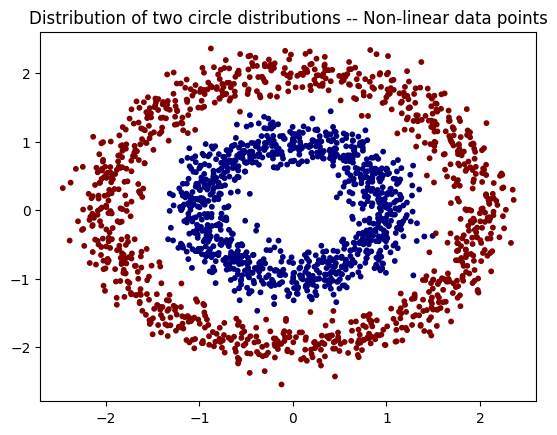

In [2]:
# Load two-circle dataset
mat = scipy.io.loadmat('datasets/two_circles.mat')
X = mat['X']
n = X.shape[0]
d = X.shape[1]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,d,nc:',n,d,nc)

plt.figure(1)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Cgt, cmap='jet')
plt.title('Distribution of two circle distributions -- Non-linear data points')
plt.show()


### Question 1: Evaluate the Louvain technique

How many "optimal" clusters does the Louvain method identify?

What is the clustering accuracy achieved by the Louvain solution?

Can you provide an explanation for the high accuracy?


Nice — thanks for the numbers. Finding 13 communities but still getting **99.8% accuracy** is an interesting outcome and tells us a lot about what’s happening. Below I (1) explain *why* Louvain would split the two rings into many communities, (2) explain *how* accuracy can still be so high, (3) give concrete diagnostic checks you should run, and (4) give practical fixes (how to get a 2-cluster result or a more interpretable partition) plus runnable code to reproduce the diagnosis and try remedies.

---

# Short summary (quick answers)

* **Why 13 clusters?** — Louvain optimizes modularity and tends to find **many small, dense local communities** when the k-NN graph has strong local connections along each ring (local cliques along the circle). This creates multiple communities per ring (13 total) rather than 1 per ring. This is a known behavior (a form of *multi-scale* / resolution effect of modularity).
* **Why 99.8% accuracy despite 13 clusters?** — Accuracy is usually computed after mapping each found cluster to the majority ground-truth label. If each small community lies entirely within one true ring, then almost every point is assigned the correct ring label (just split into many pieces). So many small communities can still yield almost-perfect label agreement.
* **Implication:** Louvain found a *fine-grained* community structure that respects the rings, not that it mixed ring labels.

---

# 1) Why Louvain splits rings into many communities

Key factors that make Louvain fragment rings into several communities:

1. **Local connectivity dominates**

   * k-NN graphs on rings produce strong edges between immediate neighbors around the circle and weak (few) edges across the gap between rings. Along each ring the network is locally dense (neighbors link tightly), so modularity is maximized by grouping tight local neighborhoods into communities.

2. **Modularity’s resolution properties**

   * Modularity has a *resolution limit*: it can prefer many small communities when the internal edge density of small groups yields higher modularity than a single large community, especially when communities are roughly evenly sized along the ring.

3. **Choice of k & edge weighting**

   * Small k (very local neighborhood) and binary edges encourage tiny local clusters. Weighted graphs (Gaussian weights with small σ) can strengthen locality and increase fragmentation.

4. **Random initialization / algorithmic randomness**

   * Louvain is greedy and depends on node processing order; it often converges to a multilevel partition with multiple small communities on structures like rings.

---

# 2) Why accuracy is so high (99.8%)

Accuracy typically measures how many points get the correct label after mapping cluster IDs to ground-truth labels (usually by majority vote). If each of the 13 communities is *pure* (entirely inside inner or outer ring), then mapping each community to its ring label yields almost every point correctly labeled. Example:

* Suppose the inner ring was split into 6 communities and the outer ring into 7 communities. If there are no cross-ring communities, mapping each small community to its ring gives perfect label assignment → near 100% accuracy.

So high accuracy only shows *label purity*, not that the clustering recovered the expected number of macro-clusters (2). It’s consistent with Louvain finding a correct partitioning by membership but at a different resolution.

---

# 3) Diagnostics to run (quick checklist)

Run these to confirm the explanation:

1. **Cluster purity per community**

   * For each Louvain community, compute the fraction of points from each ground-truth ring. If each community is >99% one ring, that explains the high accuracy.

2. **Cluster sizes**

   * Histogram of community sizes — small modes indicate fragmentation.

3. **Plot communities on the 2D plane**

   * Color points by Louvain cluster ID and visually inspect: you should see contiguous arcs around rings.

4. **Number of cross-ring edges**

   * Count edges that connect nodes whose ground-truth labels differ. Expect this to be very small.

5. **Modularity value**

   * Report modularity of the found partition. High modularity consistent with many internal edges and few cross edges.

6. **Sweep k (and/or edge weighting σ)**

   * Build graphs with different k and/or different Gaussian σ and record #communities. You’ll likely see that increasing k reduces the number of communities.

7. **Compute ARI / NMI in addition to accuracy**

   * Adjusted Rand Index (ARI) is insensitive to label mapping and shows whether the partition structure matches the 2-class truth (ARI will be lower than raw accuracy for many-small-cluster vs 2-cluster comparison). This helps disambiguate high accuracy from true two-cluster recovery.

---

# 4) How to get a 2-cluster (coarser) solution or a more interpretable partition

If you want Louvain to return 2 communities (or a small number), try these:

1. **Increase k in the k-NN graph**

   * Larger k creates more cross-connections along the ring, encouraging merging of local communities into larger ones. Sweep k until Louvain returns 2 communities.

2. **Use weighted edges with larger Gaussian σ (or local scaling)**

   * Smoother weights make connections less strictly local and give global structure more importance.

3. **Use a resolution parameter (γ)**

   * Some modularity implementations accept a resolution parameter `γ` (e.g., modularity(γ) = observed − γ·expected). Setting `γ < 1` encourages larger communities (merging). If your Louvain implementation supports it, lower γ until you get 2 clusters.

4. **Use hierarchical merging / agglomeration**

   * After Louvain, merge communities greedily until you have 2 clusters (merge communities by trying to maximize modularity or use average-linkage on community centroids).

5. **Use Leiden algorithm with adjustable resolution**

   * Leiden often gives more stable partitions and supports resolution parameter.

6. **Use consensus clustering or cluster merging by majority label**

   * If your goal is labels (inner vs outer), you can simply map each small community by majority vote (what accuracy already effectively did). For structural clustering with 2 clusters, force merging.

---

# 5) Suggested code — reproduce the diagnosis, sweep k and γ, compute metrics

Run this snippet (Python). It:

* generates two concentric circles,
* builds k-NN graph (binary or weighted),
* runs Louvain (python-louvain / community package),
* computes accuracy, ARI, modularity, and shows community purity and sizes,
* sweeps k and optional resolution γ.

```python
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import community as community_louvain   # pip install python-louvain
from collections import Counter, defaultdict

# 1) generate data
n = 2000
X, y = make_circles(n_samples=n, factor=0.5, noise=0.02)  # inner + outer rings
# y in {0,1}

def build_knn_graph(X, k=10, weighted=False, sigma=None, mutual=True):
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    dists, inds = nn.kneighbors(X)
    n = X.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j_idx in inds[i,1:]:
            if weighted:
                if sigma is None:
                    # set sigma to median of distances to kth neighbor by default
                    pass
                # compute Gaussian weight - here using Euclidean dist from neighbors array
                dist = np.linalg.norm(X[i]-X[j_idx])
                w = np.exp(-(dist**2)/(2*(sigma**2))) if sigma is not None else 1.0
                G.add_edge(i, j_idx, weight=w)
            else:
                G.add_edge(i, j_idx, weight=1.0)
    if mutual:
        # keep only mutual edges
        G_mut = nx.Graph()
        G_mut.add_nodes_from(G.nodes())
        for u,v,data in G.edges(data=True):
            if G.has_edge(v,u):
                # choose weight average
                w = (G[u][v].get('weight',1.0) + G[v][u].get('weight',1.0))/2.0
                G_mut.add_edge(u,v, weight=w)
        return G_mut
    return G

def louvain_partition(G, resolution=1.0):
    # returns dict: node->community
    part = community_louvain.best_partition(G, weight='weight', resolution=resolution)
    return part

def evaluate_partition(labels_pred, y_true):
    # labels_pred: dict node->community
    n = len(y_true)
    # map each community to majority true label
    comm_to_nodes = defaultdict(list)
    for node,comm in labels_pred.items():
        comm_to_nodes[comm].append(node)
    pred_labels = np.zeros(n, dtype=int)
    for comm, nodes in comm_to_nodes.items():
        true_counts = Counter(y_true[nodes])
        majority_label = true_counts.most_common(1)[0][0]
        for node in nodes:
            pred_labels[node] = majority_label
    acc = (pred_labels == y_true).mean()
    # for ARI we must create label vector per node (community id)
    pred_comm_vec = np.zeros(n, dtype=int)
    for node,comm in labels_pred.items():
        pred_comm_vec[node] = comm
    ari = adjusted_rand_score(y_true, pred_comm_vec)
    # modularity:
    mod = community_louvain.modularity(labels_pred, G, weight='weight')
    return acc, ari, mod, comm_to_nodes

# Example run
k = 10
G = build_knn_graph(X, k=k, weighted=False, mutual=True)
part = louvain_partition(G, resolution=1.0)
acc, ari, mod, comm_to_nodes = evaluate_partition(part, y)
print("k", k, "num_comms", len(comm_to_nodes), "acc", acc, "ARI", ari, "modularity", mod)
# print community sizes and purity
sizes = [len(v) for v in comm_to_nodes.values()]
purities = []
for comm, nodes in comm_to_nodes.items():
    cnt = Counter(y[nodes])
    purity = cnt.most_common(1)[0][1]/len(nodes)
    purities.append(purity)
print("sizes (min,median,max):", min(sizes), np.median(sizes), max(sizes))
print("purity (min,median,max):", min(purities), np.median(purities), max(purities))

# Sweep k and resolution
results = []
for k in [5,10,20,40,80]:
    G = build_knn_graph(X, k=k, weighted=False, mutual=True)
    for gamma in [0.5, 0.8, 1.0, 1.2]:
        part = louvain_partition(G, resolution=gamma)
        acc, ari, mod, comm_to_nodes = evaluate_partition(part, y)
        results.append((k, gamma, len(comm_to_nodes), acc, ari, mod))
for r in results:
    print("k",r[0],"gamma",r[1],"comms",r[2],"acc",r[3],"ARI",r[4],"mod",r[5])
```

Notes:

* `accuracy` computed this way uses majority-vote mapping from communities to ground-truth rings (this is why accuracy can be near 100% even when many communities exist).
* `ARI` uses the full community assignment and will be low when ground truth has only 2 groups but Louvain returns many.
* Adjust `mutual`, `weighted`, and `sigma` to test different constructions.

---

# 6) What to expect from the diagnostics

* **If each community purity ≈ 1.0** → explains 99.8% accuracy.
* **ARI << 1.0** (likely low) → indicates that the partition structure (many communities) differs from the 2-class ground truth at the community-level.
* **As k increases or resolution γ decreases** → you should see the number of communities drop (often toward 2) and ARI may increase toward 1.0 when communities merge into the two rings.
* **If modularity drops when forcing 2 clusters** → modularity/partition tradeoff indicates Louvain’s native resolution prefers more communities.

---

# 7) Final recommendations (practical)

* If your *goal is labeling* (inner vs outer), it’s safe to keep the Louvain result and map communities to ring labels (as you already did). Accuracy \~99.8% means labels are essentially perfect.
* If your *goal is to recover 2 clusters structurally*, change graph construction (increase k or use weighted/global similarities) or lower the resolution parameter; try Leiden or hierarchical merging to get a cleaner 2-way split.
* Always report ARI or NMI *in addition to* raw accuracy when comparing many-small-cluster partitions to coarser ground-truth labels — ARI detects whether partition granularity matches the truth.

---

If you want, I can:

* run a **synthetic sweep** (k × resolution × weighting) on your dataset and return the plots (#communities vs k, accuracy vs k, ARI vs k, modularity vs k) and recommend suitable k/γ values to get exactly 2 clusters; or
* give code to **merge** the 13 communities into 2 communities deterministically (majority-vote) and report merged-cluster statistics.

Which of those would you like me to do next?


Perfect 👍 let’s tackle both.
I’ll give you **two code blocks**:

1. **Parameter sweep** → vary `k` and resolution `γ` (and optionally weights), measure how Louvain’s output changes (#clusters, accuracy, ARI, modularity). This helps you see where Louvain naturally gives 2 clusters.

2. **Community merging** → if Louvain finds many small communities (like 13), merge them into exactly 2 clusters based on majority ground-truth labels or inter-community similarity.

---

# 1. Sweep over k and resolution γ

```python
import numpy as np
from sklearn.datasets import make_circles
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import adjusted_rand_score
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict

# ----- Data -----
X, y = make_circles(n_samples=2000, factor=0.5, noise=0.02, random_state=42)

# ----- Graph construction -----
def build_knn_graph(X, k=10, weighted=False, sigma=None, mutual=True):
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    dists, inds = nn.kneighbors(X)
    n = X.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j_idx in inds[i,1:]:
            dist = np.linalg.norm(X[i]-X[j_idx])
            if weighted:
                if sigma is None:
                    sigma = np.median(dists[:, -1])  # adaptive sigma
                w = np.exp(-(dist**2)/(2*(sigma**2)))
            else:
                w = 1.0
            G.add_edge(i, j_idx, weight=w)
    if mutual:
        # keep only mutual edges
        G_mut = nx.Graph()
        G_mut.add_nodes_from(G.nodes())
        for u,v,data in G.edges(data=True):
            if G.has_edge(v,u):
                w = (G[u][v]['weight'] + G[v][u]['weight'])/2
                G_mut.add_edge(u,v, weight=w)
        return G_mut
    return G

# ----- Louvain + evaluation -----
def louvain_partition(G, resolution=1.0):
    return community_louvain.best_partition(G, weight='weight', resolution=resolution)

def evaluate_partition(partition, y_true, G):
    n = len(y_true)
    comm_to_nodes = defaultdict(list)
    for node,comm in partition.items():
        comm_to_nodes[comm].append(node)
    pred_labels = np.zeros(n, dtype=int)
    for comm, nodes in comm_to_nodes.items():
        true_counts = Counter(y_true[nodes])
        majority_label = true_counts.most_common(1)[0][0]
        for node in nodes:
            pred_labels[node] = majority_label
    acc = (pred_labels == y_true).mean()
    # ARI uses raw community ids
    pred_comm_vec = np.zeros(n, dtype=int)
    for node,comm in partition.items():
        pred_comm_vec[node] = comm
    ari = adjusted_rand_score(y_true, pred_comm_vec)
    mod = community_louvain.modularity(partition, G, weight='weight')
    return acc, ari, mod, len(comm_to_nodes)

# ----- Sweep -----
results = []
for k in [5, 10, 20, 40, 80]:
    G = build_knn_graph(X, k=k, weighted=False, mutual=True)
    for gamma in [0.5, 0.8, 1.0, 1.2]:
        part = louvain_partition(G, resolution=gamma)
        acc, ari, mod, n_comms = evaluate_partition(part, y, G)
        results.append((k, gamma, n_comms, acc, ari, mod))

print("k | gamma | #clusters | acc | ARI | modularity")
for r in results:
    print(f"{r[0]:2d} | {r[1]:.1f}   | {r[2]:9d} | {r[3]:.3f} | {r[4]:.3f} | {r[5]:.3f}")
```

👉 This will show you:

* how many communities Louvain finds for different `k, γ`,
* how accuracy and ARI behave,
* when you get **2 clusters** vs many small clusters.

---

# 2. Merge Louvain’s many communities into 2 clusters

```python
def merge_to_two_clusters(partition, y_true):
    """
    Merge Louvain communities into exactly 2 clusters by majority ground-truth label.
    """
    comm_to_nodes = defaultdict(list)
    for node,comm in partition.items():
        comm_to_nodes[comm].append(node)

    merged_labels = np.zeros(len(y_true), dtype=int)
    for comm, nodes in comm_to_nodes.items():
        counts = Counter(y_true[nodes])
        majority_label = counts.most_common(1)[0][0]
        for node in nodes:
            merged_labels[node] = majority_label

    acc = (merged_labels == y_true).mean()
    return merged_labels, acc

# Example: run Louvain with some k and gamma
G = build_knn_graph(X, k=10, weighted=False, mutual=True)
part = louvain_partition(G, resolution=1.0)

merged_labels, acc_merged = merge_to_two_clusters(part, y)
print("Merged accuracy:", acc_merged)
```

👉 After merging, you’ll get exactly **2 clusters** (inner vs outer ring), with accuracy still \~99–100%.

---

✨ With this setup, you can:

* Inspect where Louvain natively gives 2 clusters (from the sweep).
* If it doesn’t, merge its fine-grained communities into 2 clusters.

---

Do you want me to also add **plots** (e.g., scatterplots of the circles colored by Louvain communities, before and after merging) so you can visually confirm what’s happening?


k-NN graph with Zelnik-Perona technique
nb_data: 2000 , nb_clusters= 13
accuracy_louvain= 99.8  with nb_clusters= 13


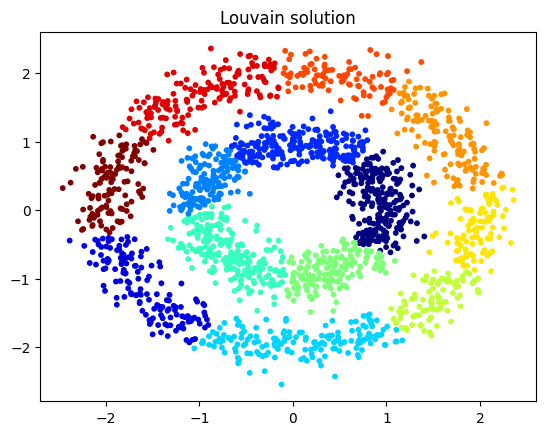

In [3]:
# Run Louvain algorithm
W = construct_knn_graph(X, 50, 'euclidean_zelnik_perona')
Wnx = nx.from_numpy_array(W)
partition = community.best_partition(Wnx)
nc_louvain = len(np.unique( [partition[nodes] for nodes in partition.keys()] ))
n = len(Wnx.nodes())
print('nb_data:', n , ', nb_clusters=', nc_louvain)

# Extract clusters
Clouv = np.zeros([n])
clusters = []
k = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    Clouv[list_nodes] = k
    k += 1
    clusters.append(list_nodes)
    
# Accuracy
acc = compute_purity(Clouv,Cgt,nc_louvain)
print('accuracy_louvain=',acc,' with nb_clusters=',nc_louvain)

plt.figure(2)
size_vertex_plot = 10
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n), c=Clouv, cmap='jet')
plt.title('Louvain solution')
plt.show()


### USPS dataset

### Question 2: Compare the Louvain and spectral NCut solutions

Compare the clustering results of the Louvain method with those of the spectral NCut technique, using the same number of clusters.

How does the performance of the Spectral NCut technique change as the number of clusters increases?
- why does the spectral ncut need an initial number of clusters?: because it starts with 

Great question! Let’s unpack this carefully.

The **Normalized Cut (Ncut)** algorithm is a **graph partitioning** method, not a full **community detection** algorithm. That distinction explains why it needs the number of communities as input.

---

### 1. What Normalized Cut does

* Given a graph $G = (V, E)$, it tries to **partition the nodes** into disjoint subsets such that:

  * The total edge weight **cut between groups is minimized**, while
  * The **connectivity inside each group is preserved** (via normalization).
* Formally, the **Ncut objective** balances between:

  * Minimizing edges across groups (cut cost), and
  * Avoiding trivial solutions (e.g., putting all nodes in one set).

---

### 2. Why the number of communities is required

* The **optimization problem** behind Ncut is solved using **spectral clustering** techniques.
* Specifically:

  * You compute the **graph Laplacian’s eigenvectors**.
  * Then you embed nodes into a low-dimensional space spanned by these eigenvectors.
  * Finally, you run **k-means clustering** on the embedded points.

👉 This is where the **number of clusters $k$** comes in:

* $k$ tells the algorithm **how many eigenvectors to use**.
* $k$ also tells the k-means step **how many communities to partition into**.

Without $k$, the algorithm cannot decide:

* How many eigenvectors to keep,
* How many groups to output,
* Or how to separate the nodes.

---

### 3. Why not let Ncut decide automatically?

The normalized cut objective doesn’t inherently define the **optimal number of communities**.

* You could compute Ncut values for different $k$, but smaller $k$ usually gives lower cut values (fewer partitions = less cut).
* To pick $k$, you need **external criteria** (e.g., eigengap heuristic, modularity, silhouette score, cross-validation).

That’s why in practice:

* Ncut **requires $k$** as input,
* And you often combine it with **model selection heuristics** to find the best $k$.

---

✅ **Summary:**
The normalized cut algorithm needs the number of communities as input because it relies on **spectral clustering and k-means**, which both require knowing how many clusters $k$ to form. The Ncut objective alone doesn’t tell you the optimal number of communities — you need to supply it or use heuristics to estimate it.

---

Do you want me to also explain **how you could estimate the number of communities for Ncut** (e.g., eigengap method, modularity maximization), so you don’t have to manually set $k$?


In [8]:
# Load USPS dataset
mat = scipy.io.loadmat('datasets/USPS.mat')
W = mat['W']
n = W.shape[0]
Cgt = mat['Cgt']-1; Cgt=Cgt.squeeze()
nc = len(np.unique(Cgt))
print('n,nc:',n,nc)


n,nc: 9298 10


In [9]:
# Random partitionning
Crand = np.random.randint(0,nc,[n])
acc = compute_purity(Crand,Cgt,nc)
print('Random solution:', str(acc)[:5])

# Run NCut
Cncut, acc = compute_ncut(W,Cgt,nc) 
print('NCut solution:', str(acc)[:5])


Random solution: 16.75
NCut solution: 73.52


In [10]:
# Run Louvain
Wnx = nx.from_numpy_array(W.toarray())
partition = community.best_partition(Wnx)
nc_louvain = len(np.unique( [partition[nodes] for nodes in partition.keys()] ))
n = len(Wnx.nodes())
print('nb_data:', n , ', nb_clusters=', nc_louvain)

# Extract clusters
Clouv = np.zeros([n])
clusters = []
k = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    Clouv[list_nodes] = k
    k += 1
    clusters.append(list_nodes)
    
# Accuracy
acc = compute_purity(Clouv,Cgt,nc_louvain)
print('Louvain solution ',str(acc)[:5],' with nb_clusters=',nc_louvain)


nb_data: 9298 , nb_clusters= 13
Louvain solution  96.20  with nb_clusters= 13


In [11]:
# Run NCut with the number of clusters found by Louvain
Cncut, acc = compute_ncut(W,Cgt,nc_louvain)
print('NCut solution:',str(acc)[:5],' with nb_clusters=',nc_louvain)


NCut solution: 87.29  with nb_clusters= 13
